# Notebook 2 - Mapa Geológico Preditivo

### Pré-processamento, modelagem dos dados & validação dos modelos

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: _Franco Naghetini_ & _Guilherme Silveira_

<a id='1'></a>
##  Configurações iniciais

##### Importação de bibliotecas

In [1]:
# bibliotecas base
import math                                                  # operações matemáticas triviais
import numpy as np                                           # operações numéricas de vetores
import pandas as pd                                          # manipulação de dataframes e series
from sklearn.base import BaseEstimator, TransformerMixin     # criação de transformadores customizados
from imblearn.pipeline import Pipeline                       # criação de pipelines

# bibliotecas de visualização
import matplotlib.pyplot as plt                              # visualização de dados
import seaborn as sns                                        # visualização de dados

# pré-processamento
from sklearn.preprocessing import StandardScaler             # escalonamento dos dados
from sklearn.preprocessing import MinMaxScaler               # escalonamento dos dados
from sklearn.preprocessing import RobustScaler               # escalonamento dos dados
from sklearn.feature_selection import SelectKBest            # feature selection
from sklearn.feature_selection import f_classif              # feature selection
from sklearn.feature_selection import mutual_info_classif    # feature selection
from imblearn.over_sampling import SMOTE                     # algoritmo de oversampling

# modelagem
from sklearn.linear_model import LogisticRegression          # Regressão Logística
from sklearn.naive_bayes import GaussianNB                   # Gaussian Naive Bayes
from sklearn.neighbors import KNeighborsClassifier           # KNN
from sklearn.svm import SVC                                  # SVM
from sklearn.ensemble import RandomForestClassifier          # Random Forest

# validação
from sklearn.model_selection import cross_val_score          # scores de validação cruzada
from sklearn.model_selection import RepeatedStratifiedKFold  # k-fold estratificado com múltiplas realizações
from sklearn.metrics import accuracy_score                   # métrica de acurácia
from sklearn.metrics import confusion_matrix                 # métrica de matriz de confusão
from sklearn.metrics import classification_report            # report de métricas de classificação

import warnings                                              # desabilitar avisos
warnings.filterwarnings("ignore")

%matplotlib inline

##### Importação do banco de dados

In [2]:
df_original = pd.read_csv("data/data_nb2.csv",sep=",")

In [3]:
# criação de uma cópia (deep) do dataframe original
df = df_original.copy(deep = True)

##### Visualização das primeiras linhas do banco de dados

In [4]:
df.head(10)

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B06,B07,B08,B09,R,G,B,TARGET,UNID,COD
0,639601.18,7983239.58,0.038643,1.36,11.75,4.58,7.32,3.19,11.14,0.29,...,13753,9672,7738,5071,120,189,156,7,Fm_SB_F,PP4esbf
1,639663.68,7983239.58,0.034852,1.17,11.39,4.39,6.89,3.40,11.61,0.29,...,12856,8910,7902,5067,173,182,181,7,Fm_SB_F,PP4esbf
2,639726.18,7983239.58,0.032705,0.93,11.09,4.07,6.41,3.66,12.12,0.30,...,13951,9673,8278,5074,176,166,159,7,Fm_SB_F,PP4esbf
3,639788.69,7983239.58,0.045865,0.70,11.07,3.76,6.01,3.94,12.59,0.31,...,13418,9074,7744,5084,164,141,147,7,Fm_SB_F,PP4esbf
4,639851.19,7983239.58,0.060395,0.50,11.09,3.45,5.73,4.25,12.98,0.33,...,12589,8560,7999,5066,183,145,183,7,Fm_SB_F,PP4esbf
5,639913.69,7983239.58,0.060871,0.45,10.40,2.99,5.54,4.58,13.11,0.35,...,14014,9698,8330,5073,186,185,200,7,Fm_SB_F,PP4esbf
6,639976.19,7983239.58,0.058178,0.42,8.91,2.50,5.14,4.87,12.96,0.38,...,15150,10969,7866,5081,202,217,205,7,Fm_SB_F,PP4esbf
7,640038.69,7983239.58,0.052502,0.36,6.87,2.07,4.51,5.08,12.55,0.40,...,13540,9759,10039,5061,170,216,200,7,Fm_SB_F,PP4esbf
8,639663.68,7983177.08,0.037932,1.33,11.38,4.28,6.75,3.33,11.21,0.29,...,13040,9026,7776,5063,195,171,190,7,Fm_SB_F,PP4esbf
9,639726.18,7983177.08,0.039949,1.04,10.32,3.87,6.21,3.60,11.69,0.30,...,15217,10675,8024,5079,176,167,159,7,Fm_SB_F,PP4esbf


<a id='2'></a>
## Variáveis Globais & funcões auxiliares

##### Variáveis globais

In [5]:
# coordenadas
COORD = ['X','Y']

# features
FEAT = df.columns[2:-3]

# features geofísicas
GF = FEAT[:8]

# canais radiométricos
RADIO = ['K','TH','U']

# sensores remotos
SR = FEAT[8:21]

# meta dados
META = ['UNID','COD']

# dicionário litoestratigráfico
dic_lith = {}
for k, v1, v2 in zip(df['TARGET'].unique(), df['UNID'].unique(), df['COD'].unique()):
    dic_lith[k] = [v1, v2]

##### Parâmetros dos gráficos

In [6]:
# fonte: Times New Roman, tamanho: 12
plt.rcParams.update({'font.family':'Times New Roman', 'font.size' : 12})

fs_title =  16        # tamanho da fonte dos títulos
cm       = 'Dark2'   # mapa de cores
mk       = 's'       # estilo do marcador (quadrado)
sz       =  2         # tamanho do marcador    
col      = 'orange'  # cor dos histogramas
ec       = 'black'   # cor das bordas dos histogramas

##### trainTestSplit(df :: dataframe, coords :: bool)

Realiza a divisão dos dados entre treino e teste. Para isso, é realizada uma amostragem aleatória de 100 exemplos por unidade litoestratigráfica. Caso uma unidade apresente um número de exemplos < 100, 70% de suas instâncias são aleatoriamente amostradas.

Parâmetros:
- `df` : dataframe (n, m) com os dados brutos
- `coords` : se `True`, retorna as coordenadas `X` e `Y` de treino e teste

Retorna:
- `X_train` : narray (t, m) com as features do conjunto de treino
- `y_train` : narray (t,  ) com o target do conjunto de treino
- `coord_train` : narray (t, 2) com as coordenadas do conjunto de treino (apenas se `coords = True`)
- `X_test` : narray (n-t, m) com as features do conjunto de teste
- `y_test` : narray (n-t,  ) com o target do conjunto de teste
- `coord_test` : narray (n-t, 2) com as coordenadas do conjunto de teste (apenas se `coords = True`)

In [7]:
def customTrainTestSplit(df, coords = False):
    # definição de uma semente aleatória
    np.random.seed(42)
    # embaralhando dataframe de entrada
    table = df.sample(frac = 1).reset_index(drop = True)
    # lista de unidades (classes)
    classes = table['TARGET'].unique()
    # dataframe vazio de treino
    train = pd.DataFrame()
    
    # Para cada unidade
    for c in classes:
        # dataframe filtrado para cada unidade específica
        unid = table[table['TARGET'] == c]
        # se o número de ocorrência <= 100
        if len(unid) <= 100:
            # amostragem aleatória de 70% dos exemplos da unidade
            𝒮 = unid.sample(math.ceil(len(unid) * 0.7))
        # se o número de ocorrência > 100
        else:
            # amostragem aleatória de 100 exemplos da unidade
            𝒮 = unid.sample(100)   
        # populando dataframe de treino
        train = pd.concat([train, 𝒮])
            
    # embaralhando os dados de treino  e teste
    test = table.drop(train.index).sample(frac = 1).reset_index(drop = True)
    train = train.sample(frac = 1).reset_index(drop = True)
    
    # divisão entre features e target nos dados de treino
    X_train, y_train, coord_train = train[FEAT].values, train['TARGET'].values, train[COORD].values
    # divisão entre features e target nos dados de teste
    X_test, y_test, coord_test = test[FEAT].values, test['TARGET'].values, test[COORD].values
    
    # retorna as features, target e coordenadas de treino e teste
    if coords:
        return X_train, y_train, coord_train, X_test, y_test, coord_test
    # retorna apenas as features e target de treino e teste
    else:
        return X_train, y_train, X_test, y_test

##### featureScaling(X_train :: narray, X_test :: narray, method :: class)

Realiza o escalonamento das features de treino e teste. O escalonador é treinado apenas com as features de treino `X_train`, mas não com as features de teste `X_test`. Em seguida, ambos os conjuntos de features de treino e teste são escalonados.

Parâmetros:
- `X_train` : narray (t, m) das features de treino
- `X_test` : narray (n-t, m) das features de teste
- `method` : classe que realizará o escalonamento. As três opções são: **StandardScaler** (default), **MinMaxScaler** e **RobustScaler**

Retorna:
- `X_train_scaled` : narray (t, m) das features de treino escalonadas
- `X_test_scaled` : narray (n-t,  m) das features de teste escalonadas

In [8]:
def featureScaling(X_train, X_test, method = StandardScaler()):
    # instanciando objeto StandardScaler
    scaler = method
    
    # treinando o scaler
    scaler.fit(X_train)
    
    # transformando features de treino
    X_train_scaled = scaler.transform(X_train)
    # transformando features de teste
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

##### selectFeatures(X_train :: narray, y_train :: narray, X_test :: narray,  func :: function, n_features :: int)

Seleciona as `n_features` mais importantes de acordo com uma função `func` passada pelo usuário.

Parâmetros:
- `X_train` : narray (t, m) das features de treino
- `y_train` : narray (t,  ) do target de treino
- `X_test` : narray (n-t, m) das features de teste
- `func` : função definida para selecionar as features. As duas opções são **f_classif** e **mutual_info_classif**
- `n_features` : número (int) de features a serem selecionadas. Default = 10

Retorna:
- `X_train_fs` : narray(t, n_features) das features de treino selecionadas
- `X_test_fs` : narray(n-t, n_features) das features de teste selecionadas
- `fs.scores_` : narray(n_features, ) com os scores calculados

In [9]:
def selectFeatures(X_train, y_train, X_test, func, n_features = 10):
    # instanciando seletor de features
    fs = SelectKBest(score_func = func, k = n_features)
    
    # treinando seletor de features
    fs.fit(X_train, y_train)
    
    # transformação das features de treino
    X_train_fs = fs.transform(X_train)
    # transformação das features de teste
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs.scores_

##### dicScores(score :: narray, k :: int)

Cria um dicionário com as `k` features mais importantes e seus respectivos scores `score`.

Parâmetros:
- `score` : narray (k,  ) com os scores das features mais importantes
- `k` : número (int) de features mais importantes. Default = 10

Retorna:
- `dict` : dicionário com `k` features (chaves) e `k` scores (valores)

In [10]:
def dicScores(score, k = 10):
    # dicionário vazio
    fs_dic = {}
    
    # populando o dicionário com os scores
    for f, s in zip(FEAT, list(score)):
        fs_dic[f] = round(s, 2)
    
    # ordenando dicionário de forma descendente
    list_sorted = sorted(fs_dic.items(), key = lambda x: x[1], reverse = True)
    # fatiando lista de acordo com o 'k' informado
    sliced_list = list_sorted[:k][:k]
    
    # retorna dicionário
    return dict(sliced_list)

##### plotSelectionScores(score :: narray, k :: int)

Plota um gráfico de barras com as `k` features mais importantes.

Parâmetros:
- `score` : narray (n_features, ) com os scores de importância das features
- `k` : número (int) de features mais importantes. Default = 10

Retorna:
- Gráfico de barras com as `k` features mais importantes

In [11]:
def plotSelectionScores(score, k = 10):
    # dicionário de features e seus scores
    dic = dicScores(score, k = k)
    # features
    keys = list(dic.keys())
    # scores
    values = list(dic.values())
    
    # dimensões do gráfico
    plt.figure(figsize = (k*0.6,3))
    # gráfico de barras f-score x features
    plt.bar(x = keys, height = values, color = col, edgecolor = ec)
    # título e labels
    plt.title(f"{k} features mais importantes", size = fs_title)
    plt.ylabel('Score', size = 14)
    plt.yticks(size = 12)
    plt.xticks(rotation = 45, size = 12)

    plt.tight_layout();

##### createPipeline(scaler :: class, score_func :: function, k_features :: int, oversamp :: class, clf :: class)

Cria um pipeline com as seguintes etapas:

> **1)** Escalonamento das features a partir de um escalonador `scaler`

> **2)** Seleção das `k_features` features mais importantes com base nos scores retornados por uma função `score_func`

> **3)** Oversampling do conjunto de treino a partir de uma classe `oversamp`

> **4)** Instanciação do classificador `clf`

Parâmetros:
- `scaler` : escalonador de features (**StandardScaler**, **MinMaxScaler** e **RobustScaler**)
- `score_func` : função que calcula os scores de importância (**f_classif** e **mutual_info_classif**)
- `k_features` : número (int) de  features que serão selecionadas
- `oversamp` : gerador de amostras sintéticas (**SMOTE**)
- `clf` : classificador (e.g. **SVC** e **RandomForestClassifier**)

Retorna:
- `pipeline` : pipeline com os métodos `fit( )`, `predict( )` e `fit_predict( )`

In [12]:
def createPipeline(scaler = None, score_func = None, k_features = None, oversamp = None, clf = None):
    # instanciando SelectKBest
    selector = SelectKBest(k = k_features, score_func = score_func)
    # etapas do pipeline
    steps = [('scaler', scaler), ('selector', selector), ('oversamp', oversamp), ('clf', clf)]
    # criação do pipeline
    pipeline = Pipeline(steps = steps)
    
    return pipeline

##### plotPrediction(pred :: narray, model :: string

Plota o mapa geológico preditivo para um dado modelo `model`, o mapa geológico e o mapa com os exemplos de treino.

Parâmetros:
- `yhat` : narray (n-t, ) com as predições do target de um determinado modelo
- `model` : string com o nome do modelo utilizado. Corresponde ao título do mapa geológico preditivo

Retorna:
- Mapa geológico preditivo do modelo `model`, mapa geológico de campo e o mapa com os exemplos de treino

In [13]:
def plotPrediction(yhat, model = None):
    # criação de um dataframe com as predições
    pred = pd.DataFrame(yhat, columns = ['TARGET'])
    # dataframe das coordenadas do conjunto de teste
    coord_test = test[['X','Y']]
    # concatenação entre as predições e as coordendas de teste
    df_model = pd.concat([pred, coord_test], axis = 1)
    # dataframe de treino com coordenadas e target
    df_train = train[['X', 'Y', 'TARGET']]
    # concatenação entre o dataframe de predições e o de treino
    df_model = pd.concat([df_model, df_train])
    
    # layout dos mapas
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (10.5, 5))
    
    # mapa preditivo
    p1 = ax1.scatter(data = df_model, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    fig.colorbar(p1, ax = ax1)
    ax1.set_title(model, size = fs_title)
    ax1.set_xlabel('X (m)', size = 14)
    ax1.set_ylabel('Y (m)', size = 14)
    
    # mapa geológico de campo
    p2 = ax2.scatter(data = df, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    fig.colorbar(p2, ax = ax2)
    ax2.set_title("Mapa geológico", size = fs_title)
    ax2.set_xlabel('X (m)', size = 14)
    
    # mapa dos exemplos de treino
    p3 = ax3.scatter(data = train, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    fig.colorbar(p3, ax = ax3)
    ax3.set_title("Treino", size = fs_title)
    ax3.set_xlabel('X (m)', size = 14)
    
    plt.tight_layout();

<a id='3'></a>
## Pré-processamento

### Separação entre dados de treino e teste

##### Separação entre features (X) e target (y)

In [14]:
# divisão entre features, target e coordenadas nos dados de treino e teste
X_train, y_train, coord_train, X_test, y_test, coord_test = customTrainTestSplit(df, coords = True)

# forma dos dados de treino
print('Treino -> features: {0}   ǂ  target: {1}'.format(X_train.shape, y_train.shape))
# forma dos dados de teste
print('Teste  -> features: {0} ǂ  target: {1}'.format(X_test.shape, y_test.shape))

Treino -> features: (747, 21)   ǂ  target: (747,)
Teste  -> features: (10671, 21) ǂ  target: (10671,)


##### Dataframes de treino e teste

In [15]:
# dataframe de treino
train_loc = pd.DataFrame(coord_train, columns = COORD)
train_feat = pd.DataFrame(X_train, columns = FEAT)
train = pd.concat([train_loc, train_feat], axis = 1)
train['TARGET'] = y_train
train.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
742,639913.68,7980427.08,0.014225,0.280000,2.76,2.21,2.39,6.79,13.36,0.50,...,9576.0,12670.0,18195.0,15518.0,9013.0,5094.0,197.0,61.0,129.0,8
743,637288.68,7978739.58,0.008884,0.650000,7.12,2.64,5.60,5.36,12.57,0.47,...,9487.0,13417.0,18258.0,14265.0,8448.0,5075.0,154.0,49.0,159.0,3
744,634788.68,7970614.56,0.048238,4.710000,26.29,4.22,17.35,1.23,5.71,0.22,...,8180.0,11521.0,13166.0,10334.0,8347.0,5065.0,67.0,75.0,87.0,5
745,636226.18,7970614.56,0.078434,0.960000,27.13,8.59,14.34,6.76,19.97,0.32,...,11028.0,15887.0,20224.0,14518.0,10151.0,5086.0,99.0,163.0,124.0,1
746,635913.68,7978364.58,0.051318,0.102035,4.52,2.24,2.81,6.21,13.28,0.50,...,9006.0,12081.0,16394.0,12794.0,8745.0,5074.0,145.0,158.0,79.0,4


In [16]:
# dataframe de teste
test_loc = pd.DataFrame(coord_test, columns = COORD)
test_feat = pd.DataFrame(X_test, columns = FEAT)
test = pd.concat([test_loc, test_feat], axis = 1)
test['TARGET'] = y_test
test.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
10666,636351.18,7971177.06,0.021578,1.810000,25.00000,8.07,15.51,4.22,13.11,0.31,...,11994.0,16621.0,20359.0,15390.0,9478.0,5070.0,197.0,227.0,203.0,2
10667,637538.68,7981489.58,0.062635,0.650000,2.84000,1.37,2.98,3.00,6.86,0.43,...,10505.0,14096.0,18653.0,15819.0,11530.0,5079.0,243.0,164.0,234.0,6
10668,636413.68,7977552.07,0.021436,0.250000,0.90406,2.85,2.36,12.89,12.65,0.98,...,8837.0,12545.0,16753.0,13443.0,9127.0,5072.0,154.0,204.0,155.0,4
10669,638601.18,7976302.07,0.019658,0.170000,3.57000,2.33,3.27,6.64,15.09,0.44,...,9047.0,13311.0,15941.0,12471.0,8738.0,5089.0,154.0,70.0,110.0,3
10670,638351.18,7979552.08,0.023044,0.102035,10.20000,3.48,5.89,14.99,55.92,0.31,...,9362.0,13275.0,16127.0,12094.0,8926.0,5088.0,158.0,150.0,155.0,6


##### Frequência de ocorrência dos dados de treino e teste por unidade

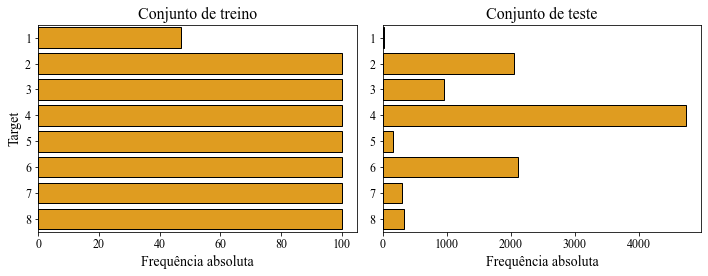

In [17]:
# layout dos plots
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# gráfico de barras dos dados de treino
sns.countplot(y = 'TARGET', data = train, color = col, edgecolor = ec, ax = axes[0])
axes[0].set_title("Conjunto de treino", size = fs_title)
axes[0].set_xlabel("Frequência absoluta", size = 14)
axes[0].set_ylabel("Target", size = 14)

# gráfico de barras dos dados de teste
sns.countplot(y = 'TARGET', data = test, color = col, edgecolor = ec, ax = axes[1])
axes[1].set_title("Conjunto de teste", size = fs_title)
axes[1].set_xlabel("Frequência absoluta", size = 14)
axes[1].set_ylabel("")

plt.tight_layout();

##### Visualização espacial dos dados de treino e teste

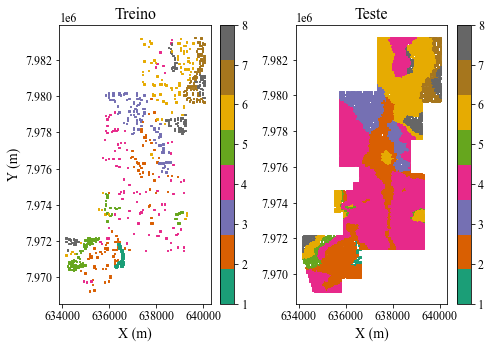

In [18]:
# layout dos plots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 5))

# Localização dos dados de treino
p1 = ax1.scatter(data = train, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
fig.colorbar(p1, ax = ax1)
ax1.set_title('Treino', size = fs_title)
ax1.set_xlabel('X (m)', size = 14)
ax1.set_ylabel('Y (m)', size = 14)

# Localização dos dados de teste
p2 = ax2.scatter(data = test, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
fig.colorbar(p2, ax = ax2)
ax2.set_title('Teste', size = fs_title)
ax2.set_xlabel('X (m)', size = 14)

plt.tight_layout();

### Escalonamento das features

#### StandardScaler

In [19]:
# normalização das features
X_train_std, X_test_std = featureScaling(X_train, X_test, method = StandardScaler())

In [20]:
# visualização das 5 primeiras linhas das features de treino normalizadas
pd.DataFrame(X_train_std, columns = df[FEAT].columns).head()

,GT,K,TH,U,CT,U_K,TH_K,U_TH,MDT,B01,...,B03,B04,B05,B06,B07,B08,B09,R,G,B
0,-0.600153,-0.819489,-0.929555,-0.807249,-0.880790,0.579727,-0.283824,1.468722,0.544021,-0.154481,...,-0.444439,-0.641561,0.020596,-0.460288,-0.412005,-0.023063,-0.546094,-0.575905,-1.232264,-0.984320
1,-0.323532,-0.563496,-0.853032,-0.154047,-0.669735,0.362712,-0.656650,3.258891,-0.526836,0.562118,...,0.227417,0.103771,-0.264109,0.992288,1.087551,-0.063676,0.073864,1.536923,0.677735,1.305105
2,-0.907067,-0.810007,1.600978,-0.051680,0.113862,0.793770,3.011119,-1.395549,1.836373,-0.582671,...,-0.334698,-0.062993,-0.440612,0.273180,-0.152171,-0.079525,0.151359,-0.969328,-1.321101,-1.334093
3,0.565171,-0.345428,0.268425,-0.037056,-0.164551,0.056511,0.463810,-0.977843,1.272156,-0.405733,...,-0.451755,-0.295271,-0.943747,-0.119061,-0.039091,-0.542117,1.856243,-1.013042,-0.699241,-1.445385
4,0.313532,2.517901,0.970324,1.040239,1.375702,-1.212882,-0.854961,-0.440792,1.110392,0.038382,...,0.613948,0.712970,0.270811,0.218765,0.057775,0.829811,0.538832,0.371225,0.381611,0.478368


#### MinMaxScaler

In [21]:
# escalonamento das features
X_train_mm, X_test_mm = featureScaling(X_train, X_test, method = MinMaxScaler())

In [22]:
# visualização das 5 primeiras linhas das features de treino normalizadas
pd.DataFrame(X_train_mm, columns = df[FEAT].columns).head()

,GT,K,TH,U,CT,U_K,TH_K,U_TH,MDT,B01,...,B03,B04,B05,B06,B07,B08,B09,R,G,B
0,0.048924,0.016886,0.048535,0.127264,0.073225,0.355093,0.102086,0.419847,0.574271,0.171112,...,0.181568,0.233967,0.616727,0.515873,0.396298,0.283627,0.376471,0.385827,0.134921,0.250000
1,0.086713,0.075364,0.068138,0.288145,0.125769,0.314012,0.053064,0.648855,0.378271,0.254206,...,0.276307,0.352989,0.582241,0.739791,0.650151,0.277184,0.470588,0.956693,0.646825,0.821429
2,0.006997,0.019052,0.696815,0.313357,0.320850,0.395611,0.535332,0.053435,0.810811,0.121461,...,0.197043,0.326359,0.560862,0.628939,0.440284,0.274670,0.482353,0.279528,0.111111,0.162698
3,0.208117,0.125179,0.355437,0.316959,0.251537,0.256050,0.200391,0.106870,0.707542,0.141978,...,0.180536,0.289266,0.499918,0.568474,0.459427,0.201288,0.741176,0.267717,0.277778,0.134921
4,0.173741,0.779267,0.535252,0.582292,0.634992,0.015757,0.026988,0.175573,0.677934,0.193476,...,0.330812,0.450272,0.647035,0.620551,0.475825,0.418919,0.541176,0.641732,0.567460,0.615079


#### RobustScaler

In [23]:
# escalonamento das features
X_train_rob, X_test_rob = featureScaling(X_train, X_test, method = RobustScaler())

In [24]:
# visualização das 5 primeiras linhas das features de treino normalizadas
pd.DataFrame(X_train_rob, columns = df[FEAT].columns).head()

,GT,K,TH,U,CT,U_K,TH_K,U_TH,MDT,B01,...,B03,B04,B05,B06,B07,B08,B09,R,G,B
0,-0.278401,-0.362069,-0.350860,-0.333333,-0.305433,0.652761,-0.028647,1.459459,0.352172,0.080660,...,-0.228225,-0.448557,0.152091,-0.327176,-0.253254,0.134521,-0.388889,-0.387387,-0.773585,-0.720000
1,0.025678,-0.129310,-0.295411,0.162963,-0.167401,0.473620,-0.427586,3.081081,-0.564816,0.823098,...,0.379272,0.199852,-0.094180,0.748671,0.905994,0.097996,0.055556,0.918919,0.443396,0.925714
2,-0.615780,-0.353448,1.482792,0.240741,0.345081,0.829448,3.497082,-1.135135,1.458829,-0.362970,...,-0.128997,0.054774,-0.246856,0.216065,-0.052386,0.083742,0.111111,-0.630631,-0.830189,-0.971429
3,1.002595,0.068966,0.517208,0.251852,0.162996,0.220859,0.771353,-0.756757,0.975683,-0.179652,...,-0.234840,-0.147298,-0.682071,-0.074447,0.035031,-0.332294,1.333333,-0.657658,-0.433962,-1.051429
4,0.725978,2.672414,1.025813,1.070370,1.170338,-0.826994,-0.639788,-0.270270,0.837163,0.280477,...,0.728776,0.729830,0.368529,0.175763,0.109915,0.901559,0.388889,0.198198,0.254717,0.331429


### Seleção de features

#### Teste f - ANOVA

In [25]:
# seleção das features (Teste f - ANOVA)
X_train_anova, X_test_anova, scores_anova = selectFeatures(X_train_std, y_train, X_test_std, f_classif, n_features = 10)

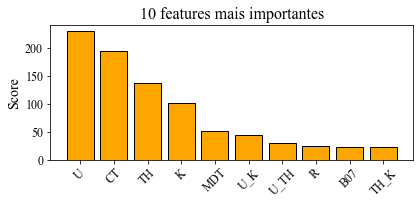

In [26]:
plotSelectionScores(scores_anova, k = 10)

In [27]:
# as 10 features "mais importantes" de acordo com o teste f (ANOVA)
anova_dic = dicScores(scores_anova, k = 10)
anova_dic

{'U': 230.73,
 'CT': 194.6,
 'TH': 137.37,
 'K': 101.07,
 'MDT': 50.5,
 'U_K': 43.38,
 'U_TH': 29.03,
 'R': 24.0,
 'B07': 22.73,
 'TH_K': 22.56}

#### Classificação por informação mútua

In [28]:
# seleção das features (informação mútua)
X_train_mut, X_test_mut, scores_mut = selectFeatures(X_train_std, y_train, X_test_std, mutual_info_classif, n_features = 10)

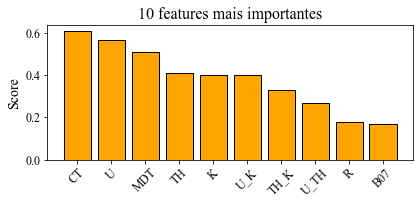

In [29]:
plotSelectionScores(scores_mut, k = 10)

In [30]:
# as 10 features "mais importantes" de acordo com a classificação por informação mútua
mutual_info_dic = dicScores(scores_mut, k = 10)
mutual_info_dic

{'CT': 0.61,
 'U': 0.57,
 'MDT': 0.51,
 'TH': 0.41,
 'K': 0.4,
 'U_K': 0.4,
 'TH_K': 0.33,
 'U_TH': 0.27,
 'R': 0.18,
 'B07': 0.17}

### Oversampling

#### SMOTE

In [31]:
# oversampling dos dados de treino
X_train_smt, y_train_smt = SMOTE().fit_resample(X_train_anova, y_train)

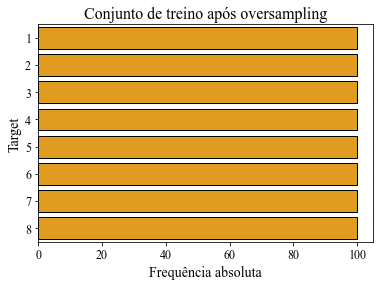

In [32]:
# transformação de narray em dataframe
train_smt = pd.DataFrame(X_train_smt, columns = anova_dic.keys())
train_smt['TARGET'] = y_train_smt

# gráfico de barras
sns.countplot(y = 'TARGET', data = train_smt, color = col, edgecolor = ec)

# título e labels do gráfico
plt.title("Conjunto de treino após oversampling", size = fs_title)
plt.xlabel("Frequência absoluta", size = 14)
plt.ylabel("Target", size = 14);

<a id='4'></a>
## Modelagem dos dados

### Regressão logística multinomial

In [33]:
# dados de treino e teste
X_train, y_train, X_test, y_test = customTrainTestSplit(df)

In [34]:
# definição do pipeline
mlr_pipe = createPipeline(scaler = StandardScaler(),
                          score_func = f_classif,
                          k_features = 10,
                          oversamp = SMOTE(random_state = 42),
                          clf = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state = 42))

In [35]:
# treinamento do classificador
mlr_pipe.fit(X_train, y_train)

# predição dos dados de teste
mlr_ŷ = mlr_pipe.predict(X_test)

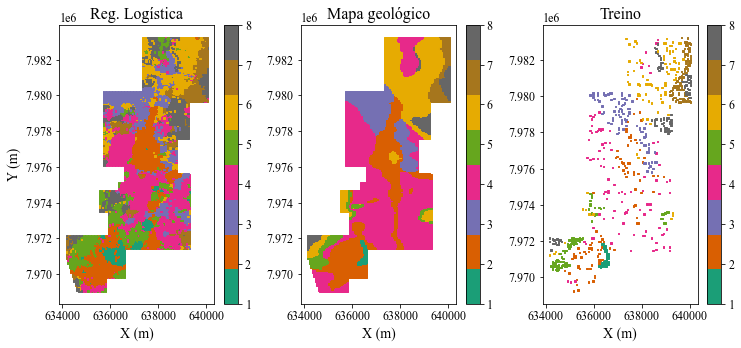

In [36]:
# visualização do mapa preditivo (Regressão Logística)
plotPrediction(mlr_ŷ, model = 'Reg. Logística')

In [37]:
# criação de um dataframe de predições por algoritmo
df_pred = pd.DataFrame()
# adicionando predições da Regressão Logística
df_pred['MLR'] = mlr_ŷ
# visualização das 5 primeiras linhas do dataframe de predições
df_pred.head()

,MLR
0,2
1,5
2,2
3,4
4,5


### Gaussian Naive Bayes

In [38]:
# dados de treino e teste
X_train, y_train, X_test, y_test = customTrainTestSplit(df)

In [39]:
# definição do pipeline
gnb_pipe = createPipeline(scaler = StandardScaler(),
                         score_func = f_classif,
                         k_features = 10,
                         oversamp = SMOTE(random_state = 42),
                         clf = GaussianNB())

In [40]:
# treinamento do classificador
gnb_pipe.fit(X_train, y_train)

# predição dos dados de teste
gnb_ŷ = gnb_pipe.predict(X_test)

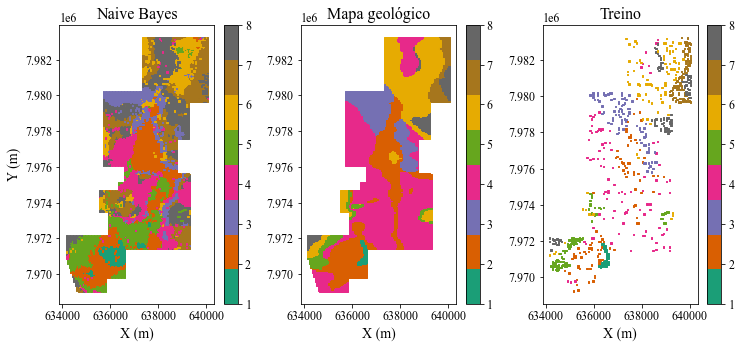

In [41]:
# visualização do mapa preditivo (Regressão Logística)
plotPrediction(gnb_ŷ, model = 'Naive Bayes')

In [42]:
# adicionando predições da Regressão Logística
df_pred['GNB'] = gnb_ŷ
# visualização das 5 primeiras linhas do dataframe de predições
df_pred.head()

,MLR,GNB
0,2,1
1,5,5
2,2,2
3,4,8
4,5,5


### K-Nearest Neighbors (KNN)

In [43]:
# dados de treino e teste
X_train, y_train, X_test, y_test = customTrainTestSplit(df)

In [44]:
# definição do pipeline
knn_pipe = createPipeline(scaler = StandardScaler(),
                         score_func = f_classif,
                         k_features = 10,
                         oversamp = SMOTE(random_state = 42),
                         clf = KNeighborsClassifier())

In [45]:
# treinamento do classificador
knn_pipe.fit(X_train, y_train)

# predição dos dados de teste
knn_ŷ = knn_pipe.predict(X_test)

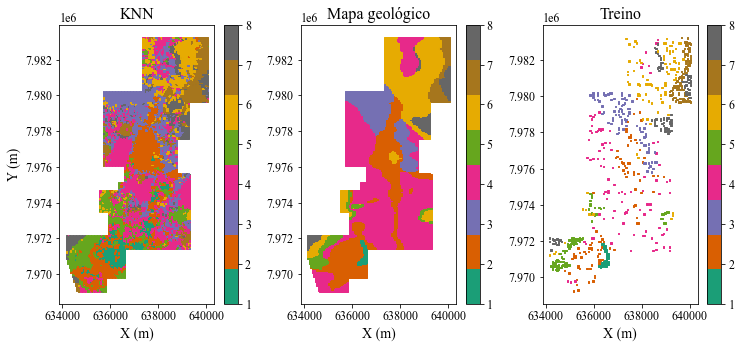

In [46]:
# visualização do mapa preditivo (KNN)
plotPrediction(knn_ŷ, model = 'KNN')

In [47]:
# adicionando predições do KNN
df_pred['KNN'] = knn_ŷ
# visualização das 5 primeiras linhas do dataframe de predições
df_pred.head()

,MLR,GNB,KNN
0,2,1,1
1,5,5,2
2,2,2,2
3,4,8,7
4,5,5,1


### Support Vector Machines (SVM)

In [48]:
# dados de treino e teste
X_train, y_train, X_test, y_test = customTrainTestSplit(df)

In [49]:
# definição do pipeline
svm_pipe = createPipeline(scaler = StandardScaler(),
                          score_func = f_classif,
                          k_features = 10,
                          oversamp = SMOTE(random_state = 42),
                          clf = SVC(random_state = 42))

In [50]:
# treinamento do classificador
svm_pipe.fit(X_train, y_train)

# predição dos dados de teste
svm_ŷ = svm_pipe.predict(X_test)

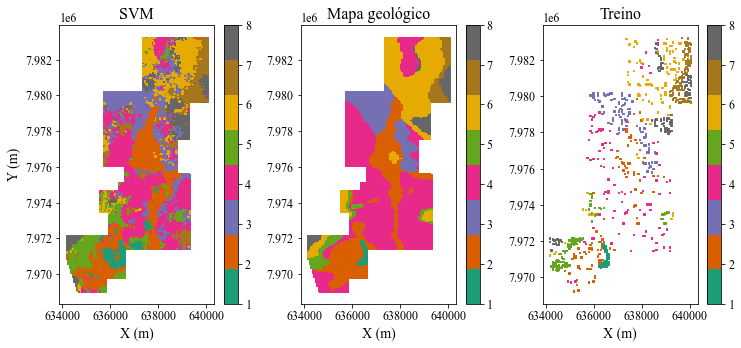

In [51]:
# visualização do mapa preditivo (SVM)
plotPrediction(svm_ŷ, model = 'SVM')

In [52]:
# adicionando coluna do SVM ao dataframe de predições
df_pred['SVM'] = svm_ŷ
# visualização do dataframe de predições
df_pred.head()

,MLR,GNB,KNN,SVM
0,2,1,1,1
1,5,5,2,2
2,2,2,2,2
3,4,8,7,6
4,5,5,1,4


### Random Forest

In [53]:
# dados de treino e teste
X_train, y_train, X_test, y_test = customTrainTestSplit(df)

In [54]:
# definição do pipeline
rf_pipe = createPipeline(scaler = StandardScaler(),
                          score_func = f_classif,
                          k_features = 10,
                          oversamp = SMOTE(random_state = 42),
                          clf = RandomForestClassifier(random_state = 42))

In [55]:
# treinamento do classificador
rf_pipe.fit(X_train, y_train)

# predição dos dados de teste
rf_ŷ = rf_pipe.predict(X_test)

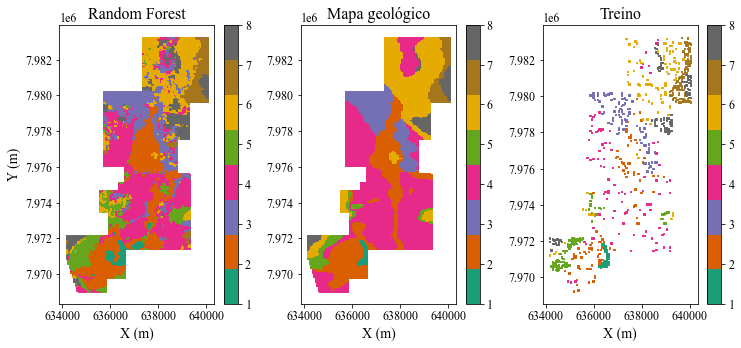

In [56]:
# visualização do mapa preditivo (Random Forest)
plotPrediction(rf_ŷ, model = 'Random Forest')

In [57]:
# adicionando coluna do Random Forest ao dataframe de predições
df_pred['RF'] = rf_ŷ
# visualização do dataframe de predições
df_pred.head()

,MLR,GNB,KNN,SVM,RF
0,2,1,1,1,2
1,5,5,2,2,2
2,2,2,2,2,2
3,4,8,7,6,4
4,5,5,1,4,4
